#Utilize GPU

In [ ]:
!nvidia-smi

Sat Nov 28 16:25:05 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.38       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P8     9W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Install packages

In [ ]:
!pip install -q -U watermark

In [ ]:
!pip install -qq transformers

     |████████████████████████████████| 1.3MB 13.8MB/s 
     |████████████████████████████████| 890kB 52.1MB/s 
     |████████████████████████████████| 1.1MB 50.2MB/s 
     |████████████████████████████████| 2.9MB 52.5MB/s 


In [ ]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

CPython 3.6.9
IPython 5.5.0

numpy 1.18.5
pandas 1.1.4
torch 1.7.0+cu101
transformers 3.5.1


In [ ]:
!git clone https://github.com/huggingface/transformers.git

Cloning into 'transformers'...
remote: Enumerating objects: 53732, done.
remote: Total 53732 (delta 0), reused 0 (delta 0), pack-reused 53732
Receiving objects: 100% (53732/53732), 40.23 MiB | 27.43 MiB/s, done.
Resolving deltas: 100% (37486/37486), done.


In [ ]:
%cd transformers

/content/transformers


In [ ]:
#!pip3 install --upgrade .

In [ ]:
!pip3 install emoji

     |████████████████████████████████| 51kB 5.7MB/s 
  Created wheel for emoji: filename=emoji-0.6.0-cp36-none-any.whl size=49716 sha256=152c6f25482fa6f3e8d93597d4bef4e39e8ce188a88a0b2ed5667f571e5bd34f
  Stored in directory: /root/.cache/pip/wheels/46/2c/8b/9dcf5216ca68e14e0320e283692dce8ae321cdc01e73e17796
Successfully built emoji


In [ ]:
!pip install tweet-preprocessor

# Import libraries

In [ ]:
import preprocessor as p
import pandas as pd
import numpy as np
from datetime import datetime
import json
import os
import pprint
import random
import string
import sys
import tensorflow as tf
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn, optim
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
from collections import defaultdict

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support

# Read and Preprocess Golden Set

In [ ]:
df_train = pd.read_csv("/content/task2_en_training.tsv",sep='\t')

In [ ]:
clean_text = []
for text in df_train['tweet']:
  clean_text.append(p.clean(text))
df_train['clean_tweet'] = clean_text
df_train.head()

,tweet_id,user_id,class,tweet,clean_tweet
0,344266386467606528,809439366,0,"depression hurts, cymbalta can help","depression hurts, cymbalta can help"
1,349220537903489025,323112996,0,"@jessicama20045 right, but cipro can make thin...","right, but cipro can make things much worse......"
2,351421773079781378,713100330,0,@fibby1123 are you on paxil .. i need help,are you on paxil .. i need help
3,326594278472171520,543113070,0,@redicine the lamotrigine and sjs just made ch...,the lamotrigine and sjs just made chaos more v...
4,345567138376994816,138795534,0,have decided to skip my #humira shot today. my...,have decided to skip my shot today. my body's ...


In [ ]:
df_train.shape

(20544, 5)

In [ ]:
df_test = pd.read_csv("/content/task2_en_test_participant.tsv",sep='\t')

In [ ]:
df_test['class'] = [0]*(df_test.shape[0])

In [ ]:
clean_text = []
for text in df_test['tweet']:
  clean_text.append(p.clean(text))
df_test['clean_tweet'] = clean_text
df_test.head()

,tweet_id,user_id,tweet,created_at,class,clean_tweet
0,1000015678282371073,1093421588,@humanponcho @LexG_III I've been taking citalo...,2018-05-25 14:08:11,0,I've been taking citalopram in the morning and...
1,1000092563037138950,276456688,TERMOTANQUE DE SALBUTAMOL!,2018-05-25 19:13:42,0,TERMOTANQUE DE SALBUTAMOL!
2,1000111775449219073,5967072,Similar to Morphine: The Best Natural Painkill...,2018-05-25 20:30:03,0,Similar to Morphine: The Best Natural Painkill...
3,1000142070399619073,1094044202,How to pronounce conjugated estrogens (#Premar...,2018-05-25 22:30:25,0,How to pronounce conjugated estrogens () (Memo...
4,1000286323134083073,607970123,I know of guys in my area that take over 2 sac...,2018-05-26 08:03:38,0,I know of guys in my area that take over sache...


In [ ]:
from sklearn.model_selection import train_test_split

train, dev = train_test_split(df_train, test_size=0.2)

In [ ]:
train.shape

(16435, 5)

In [ ]:
dev.shape

(4109, 5)

# Read and Label Silver Set

In [ ]:
add_df = pd.read_csv('/content/reddit_with_sentiment.csv', sep=',', lineterminator='\r', index_col=0)

In [ ]:
add_df.head()

,body,sentiment
0,People who have been *legally* declared [menta...,0.605967
1,&gt; why only 17% of energy is nuclear\n\nand ...,0.699032
2,Fucking gabapentin. I went to pain management ...,0.061821
3,so that means SC men would just get it illegal...,0.785086
4,Tell her to take pills or morning after pills....,0.597251


In [ ]:
add_df.shape

(402291, 2)

In [ ]:
add_df['clean_tweet'] = add_df['body']

In [ ]:
add_df['sentiment'].quantile(0.1)

0.15281373

In [ ]:
label = []
for index, row in add_df.iterrows():
  if row['sentiment'] >= 0.5:
    label.append(int(1))
  else:
    label.append(int(0))

In [ ]:
add_df['class'] = label

In [ ]:
add_df.head()

,body,sentiment,clean_tweet,class
0,People who have been *legally* declared [menta...,0.605967,People who have been *legally* declared [menta...,1
1,&gt; why only 17% of energy is nuclear\n\nand ...,0.699032,&gt; why only 17% of energy is nuclear\n\nand ...,1
2,Fucking gabapentin. I went to pain management ...,0.061821,Fucking gabapentin. I went to pain management ...,0
3,so that means SC men would just get it illegal...,0.785086,so that means SC men would just get it illegal...,1
4,Tell her to take pills or morning after pills....,0.597251,Tell her to take pills or morning after pills....,1


In [ ]:
add_df.shape

(402291, 4)

In [ ]:
silver_train, silver_dev = train_test_split(add_df, test_size=0.1)

# Load BERTweet and Tokenizer

In [ ]:
import torch
from transformers import AutoModel, AutoTokenizer 

In [ ]:
 bertweet = AutoModel.from_pretrained("vinai/bertweet-base") #bertweet = BertModel.from_pretrained('bert-base-uncased') #

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("vinai/bertweet-base") #tokenizer = BertTokenizer.from_pretrained('bert-base-uncased') #

Special tokens have been added in the vocabulary, make sure the associated word embedding are fine-tuned or trained.


# Create Data Loader for Model Feeding

In [ ]:
class ADR_dataset(Dataset):

  def __init__(self, tweets, classes, tokenizer, max_len):
    self.tweets = tweets
    self.classes = classes
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.tweets)
  
  def __getitem__(self, item):
    tweet = str(self.tweets[item])
    class_ = self.classes[item]

    encoding = self.tokenizer.encode_plus(
      tweet,
      add_special_tokens=True,
      max_length = self.max_len,
      truncation=True,
      return_token_type_ids=False,
      padding='max_length',
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'tweets': tweet,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'classes': torch.tensor(class_, dtype=torch.long)
    }

In [ ]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = ADR_dataset(
    tweets=df['clean_tweet'].to_numpy(),
    classes=df['class'].to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

In [ ]:
silver_train_loader = create_data_loader(silver_train, tokenizer, 128, 32)
silver_dev_loader = create_data_loader(silver_dev, tokenizer, 128, 32)

In [ ]:
data = next(iter(silver_train_loader))
data.keys()

dict_keys(['tweets', 'input_ids', 'attention_mask', 'classes'])

In [ ]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['classes'].shape)

torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Create the Binary Classification Model

In [ ]:
class ADR_Classifier(nn.Module):

  def __init__(self, n_classes):
    super(ADR_Classifier, self).__init__()
    self.bert = bertweet
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(pooled_output)
    return self.out(output)

In [ ]:
model = ADR_Classifier(2)
model = model.to(device)

In [ ]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([32, 128])
torch.Size([32, 128])


In [ ]:
nn.functional.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.5265, 0.4735],
        [0.5458, 0.4542],
        [0.5316, 0.4684],
        [0.5353, 0.4647],
        [0.6046, 0.3954],
        [0.5350, 0.4650],
        [0.5532, 0.4468],
        [0.5246, 0.4754],
        [0.5120, 0.4880],
        [0.5204, 0.4796],
        [0.5363, 0.4637],
        [0.5611, 0.4389],
        [0.5380, 0.4620],
        [0.5047, 0.4953],
        [0.5442, 0.4558],
        [0.5030, 0.4970],
        [0.5222, 0.4778],
        [0.5038, 0.4962],
        [0.5604, 0.4396],
        [0.5554, 0.4446],
        [0.5616, 0.4384],
        [0.5428, 0.4572],
        [0.5128, 0.4872],
        [0.4757, 0.5243],
        [0.5418, 0.4582],
        [0.5204, 0.4796],
        [0.5304, 0.4696],
        [0.5248, 0.4752],
        [0.5190, 0.4810],
        [0.5675, 0.4325],
        [0.5671, 0.4329],
        [0.5394, 0.4606]], device='cuda:0', grad_fn=<SoftmaxBackward>)

# Fine Tune with the Silver Set

In [ ]:
EPOCHS = 2 #3 #1

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False) 
total_steps = len(silver_train_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0.1*total_steps,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [ ]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    classes = d["classes"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, classes)

    correct_predictions += torch.sum(preds == classes)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      classes = d["classes"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, classes)

      correct_predictions += torch.sum(preds == classes)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  silver_train_acc, silver_train_loss = train_epoch(
    model,
    silver_train_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(silver_train)
  )

  print(f'Silver set train loss {silver_train_loss} accuracy {silver_train_acc}')

  silver_val_acc, silver_val_loss = eval_model(
    model,
    silver_dev_loader,
    loss_fn, 
    device, 
    len(silver_dev)
  )

  print(f'Siver set val   loss {silver_val_loss} accuracy {silver_val_acc}')
  print()

  history['silver_train_acc'].append(silver_train_acc)
  history['silver_train_loss'].append(silver_train_loss)
  history['silver_val_acc'].append(silver_val_acc)
  history['silver_val_loss'].append(silver_val_loss)

  if silver_val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = silver_val_acc

Epoch 1/2
----------
Silver set train loss 0.38670221179644726 accuracy 0.8163154827501443
Siver set val   loss 0.3500250800052252 accuracy 0.8412130251056426

Epoch 2/2
----------
Silver set train loss 0.29347244433291547 accuracy 0.8660308622027779
Siver set val   loss 0.3340922963578959 accuracy 0.8555306984837187

CPU times: user 2h 36min 28s, sys: 1h 42min 48s, total: 4h 19min 16s
Wall time: 4h 20min 29s


# Fine Tune with the Golden Set

In [ ]:
BATCH_SIZE = 32 #16
MAX_LEN = 120

In [ ]:
train_data_loader = create_data_loader(train, tokenizer, MAX_LEN, BATCH_SIZE)
dev_data_loader = create_data_loader(dev, tokenizer, MAX_LEN, BATCH_SIZE)

In [ ]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['tweets', 'input_ids', 'attention_mask', 'classes'])

In [ ]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['classes'].shape)

torch.Size([32, 120])
torch.Size([32, 120])
torch.Size([32])


In [ ]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([32, 120])
torch.Size([32, 120])


In [ ]:
nn.functional.softmax(model(input_ids, attention_mask), dim=1)

tensor([[9.9912e-01, 8.7949e-04],
        [9.9546e-01, 4.5443e-03],
        [9.3669e-01, 6.3312e-02],
        [9.9913e-01, 8.6896e-04],
        [2.2781e-02, 9.7722e-01],
        [9.8167e-01, 1.8326e-02],
        [9.3707e-01, 6.2927e-02],
        [1.0036e-02, 9.8996e-01],
        [9.9908e-01, 9.2184e-04],
        [9.9909e-01, 9.0623e-04],
        [8.9593e-01, 1.0407e-01],
        [6.1175e-04, 9.9939e-01],
        [9.9772e-01, 2.2823e-03],
        [6.7165e-04, 9.9933e-01],
        [9.9919e-01, 8.0958e-04],
        [9.0549e-01, 9.4513e-02],
        [9.9901e-01, 9.9281e-04],
        [6.7906e-01, 3.2094e-01],
        [6.0847e-04, 9.9939e-01],
        [9.9919e-01, 8.0708e-04],
        [1.2875e-01, 8.7125e-01],
        [9.3230e-01, 6.7703e-02],
        [9.6832e-03, 9.9032e-01],
        [9.9908e-01, 9.2454e-04],
        [9.8816e-01, 1.1841e-02],
        [3.1802e-03, 9.9682e-01],
        [7.6125e-04, 9.9924e-01],
        [2.3073e-03, 9.9769e-01],
        [9.9900e-01, 9.9637e-04],
        [9.950

In [ ]:
EPOCHS = 14 #5 #10 #20 #8 #3 #5 #8 #10

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False) #change lr from 2e-5 to 5e-5
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0.1*total_steps,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [ ]:
def get_predictions(model, data_loader):
  model = model.eval()
  
  tweets = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["tweets"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      classes = d["classes"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = nn.functional.softmax(outputs, dim=1)

      tweets.extend(tweets)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(classes)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return tweets, predictions, prediction_probs, real_values

In [ ]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    dev_data_loader,
    loss_fn, 
    device, 
    len(dev)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  #print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc
  
  y_tweets, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  dev_data_loader
  )
  f1_score = precision_recall_fscore_support(y_test, y_pred)[2][1]

  print(f'Val    f1-score {f1_score}')
  print()
  history['f1_score'].append(f1_score) 


Epoch 1/14
----------
Train loss 0.40283549143407305 accuracy 0.8814116215393977
Val   loss 0.1945483053839484 accuracy 0.9238257483572645
Val    f1-score 0.5522174535050072

Epoch 2/14
----------
Train loss 0.1748454860114431 accuracy 0.9329479768786128
Val   loss 0.20395527411136746 accuracy 0.929423217327817
Val    f1-score 0.5772594752186588

Epoch 3/14
----------
Train loss 0.1168782402342729 accuracy 0.9580772741101308
Val   loss 0.24947916728610448 accuracy 0.9262594305183742
Val    f1-score 0.6130268199233717

Epoch 4/14
----------
Train loss 0.07387119173258 accuracy 0.9780346820809248
Val   loss 0.3261059791611349 accuracy 0.9104404964711609
Val    f1-score 0.6109936575052853

Epoch 5/14
----------
Train loss 0.05814564976977558 accuracy 0.9835108001216916
Val   loss 0.3339888104797132 accuracy 0.919201752251156
Val    f1-score 0.6148491879350347

Epoch 6/14
----------
Train loss 0.03339143646568429 accuracy 0.9912990568907819
Val   loss 0.3506170604396034 accuracy 0.93064005

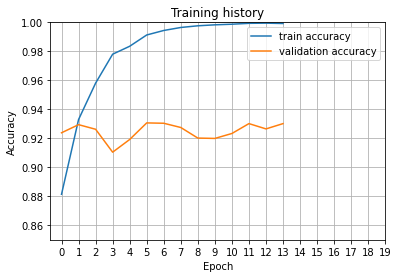

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')
plt.grid(axis='both')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.xticks(ticks=range(20))
plt.legend()
plt.ylim([0.85, 1]);

(0.4, 0.8)

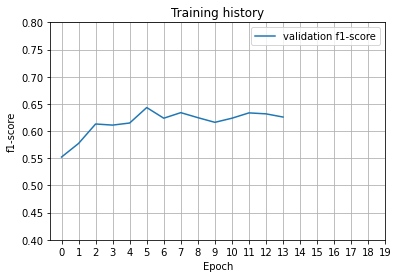

In [ ]:
plt.plot(history['f1_score'], label='validation f1-score')
plt.grid(axis='both')
plt.title('Training history')
plt.ylabel('f1-score')
plt.xlabel('Epoch')
plt.xticks(ticks=range(20))
plt.legend()
plt.ylim([0.4, 0.8])

# Evaluation on the Dev Set

In [ ]:
test_acc, _ = eval_model(
  model,
  dev_data_loader,
  loss_fn,
  device,
  len(dev)
)

test_acc.item()

0.9301533219761499

In [ ]:
y_tweets, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  dev_data_loader
)

In [ ]:
print('precision:', precision_recall_fscore_support(dev['class'], y_pred)[0][1])
print('recall:', precision_recall_fscore_support(dev['class'], y_pred)[1][1])
print('f1_score:', precision_recall_fscore_support(dev['class'], y_pred)[2][1])

precision: 0.6299212598425197
recall: 0.6217616580310881
f1_score: 0.6258148631029986


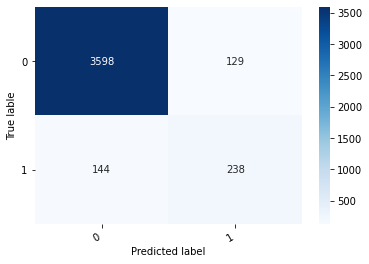

In [ ]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True lable')
  plt.xlabel('Predicted label');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm)
show_confusion_matrix(df_cm)

In [ ]:
group = []
for index, row in dev.iterrows():
  if row['class'] == 1:
    if row['pred'] == 1:
      group.append('TP')
    else:
      group.append('FN')
  else:
    if row['pred'] == 1:
      group.append('FP')
    else:
      group.append('TN')
dev['group'] = group
dev.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


,tweet_id,user_id,class,tweet,clean_tweet,pred,prob,group
6565,430820666170818561,74008439,0,and obama's deal w/big pharma made the much mo...,and obama's deal w/big pharma made the much mo...,0,0.999052,TN
18909,530914398194266112,2514112999,0,i have to voice one more thing..im left w noon...,i have to voice one more thing..im left w noon...,0,0.998964,TN
11638,540441759889625088,2808223652,0,name: kaylee hogan. i'm a carpenter and i like...,name: kaylee hogan. i'm a carpenter and i like...,0,0.999088,TN
13248,483211325284179968,2350639447,0,@doctortranri360 the clinical trial studying p...,the clinical trial studying pts on exubera has...,0,0.998998,TN
19460,537747355815014400,1288832539,0,"yup, just lit up some basswood n pressing a cu...","yup, just lit up some basswood n pressing a cu...",0,0.998866,TN


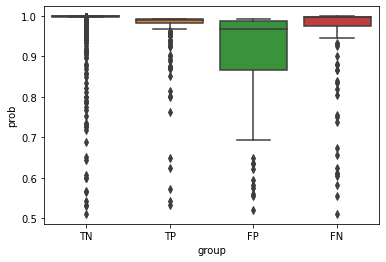

In [ ]:
sns.boxplot(x='group', y='prob', data=dev)

# Predict the Test Set

In [ ]:
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [ ]:
y_tweets, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

In [ ]:
df_test['Class'] = y_pred

# Create the File for Submission

In [ ]:
df_test.to_csv('/content/prediction_task2_en.tsv',sep='\t')